# Multivariate Forecasting  
This notebook outlines an example of scalecast using multiple series to forecast one another using scikit-learn models.

The data is available on Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices  
See the blog post: https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

In [2]:
# read data
data = pd.read_csv(r'C:\Users\jinlei\Documents\2023\mikekeith52\data\avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

We will be forecasting the organic and conventional avocado sales from California only.

In [3]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']

## Choose Models and Import Validation Grids

In [4]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

## EDA

### Plot

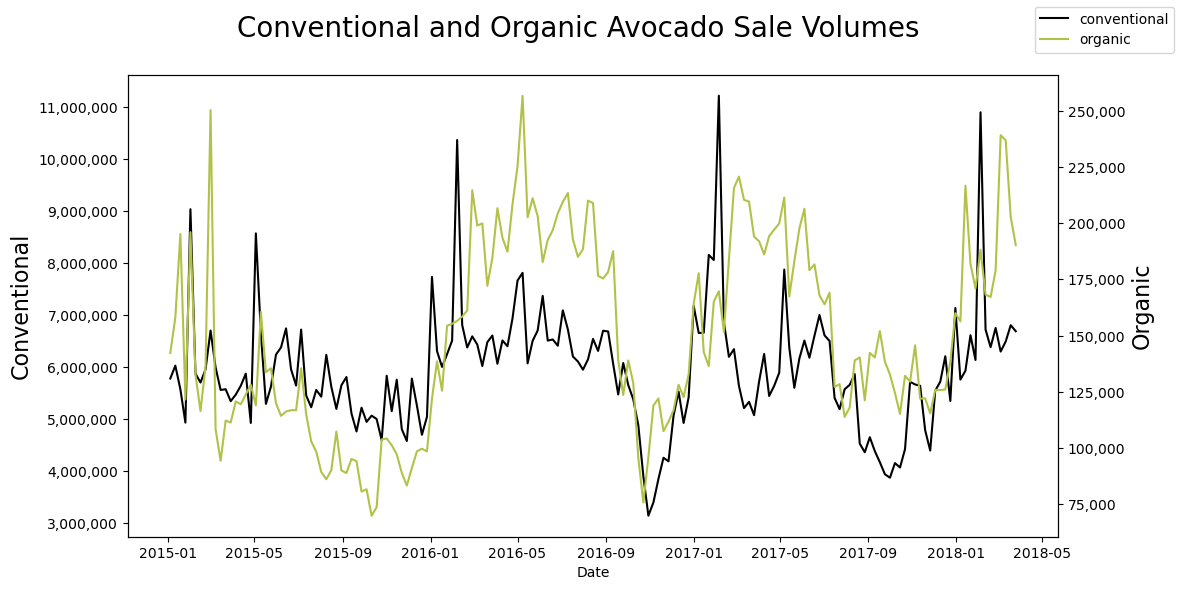

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_con,
    label='conventional',
    ax=ax,
    color='black',
    legend=False
)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_org,
    label='organic',
    ax=ax2,
    color='#B2C248',
    legend=False
)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()

### Examine Correlation between the series

In [6]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


### Load into Forecaster from scalecast

In [7]:
fcon = Forecaster(
    y=data_cali_con['Total Volume'],
    current_dates = data_cali_con['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [8]:
forg = Forecaster(
    y=data_cali_org['Total Volume'],
    current_dates = data_cali_org['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### ACF and PACF Plots

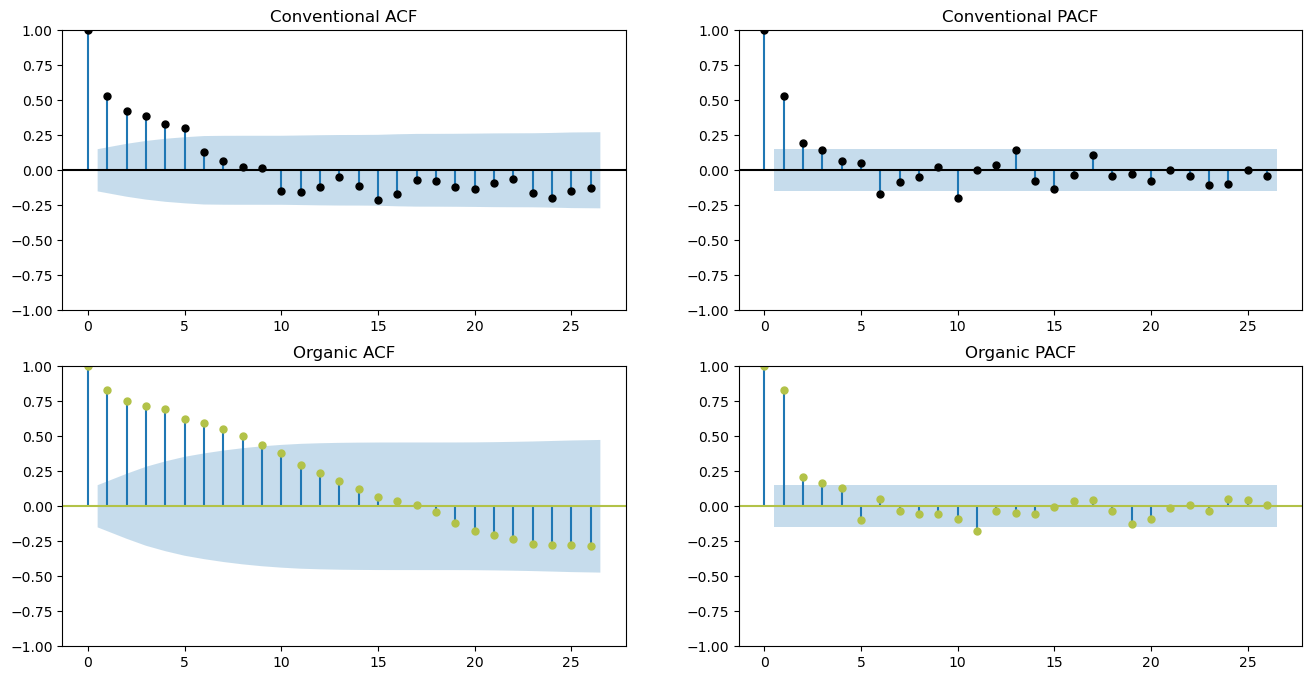

In [9]:
figs, axs = plt.subplots(2, 2,figsize=(16,8))
fcon.plot_acf(
    ax=axs[0,0],
    title='Conventional ACF',
    lags=26,
    color='black'
)
fcon.plot_pacf(
    ax=axs[0,1],
    title='Conventional PACF',
    lags=26,
    color='black',
    method='ywm'
)
forg.plot_acf(
    ax=axs[1,0],
    title='Organic ACF',
    lags=26,
    color='#B2C248'
)
forg.plot_pacf(
    ax=axs[1,1],
    title='Organic PACF',
    lags=26,
    color='#B2C248',
    method='ywm'
)
plt.show()

### Seasonal Decomposition Plots

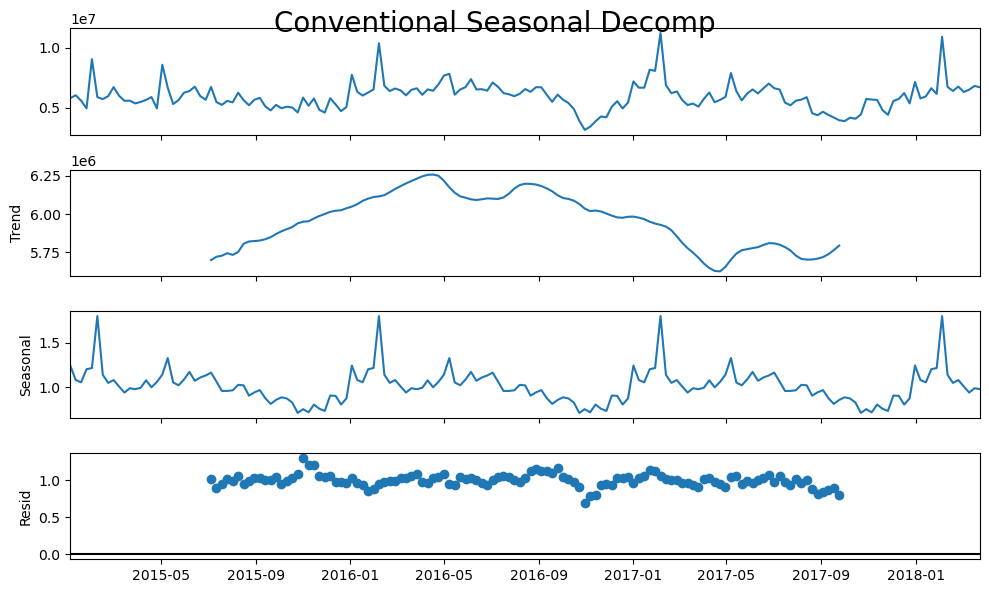

In [10]:
plt.rc("figure",figsize=(10,6))
fcon.seasonal_decompose(model='mul').plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

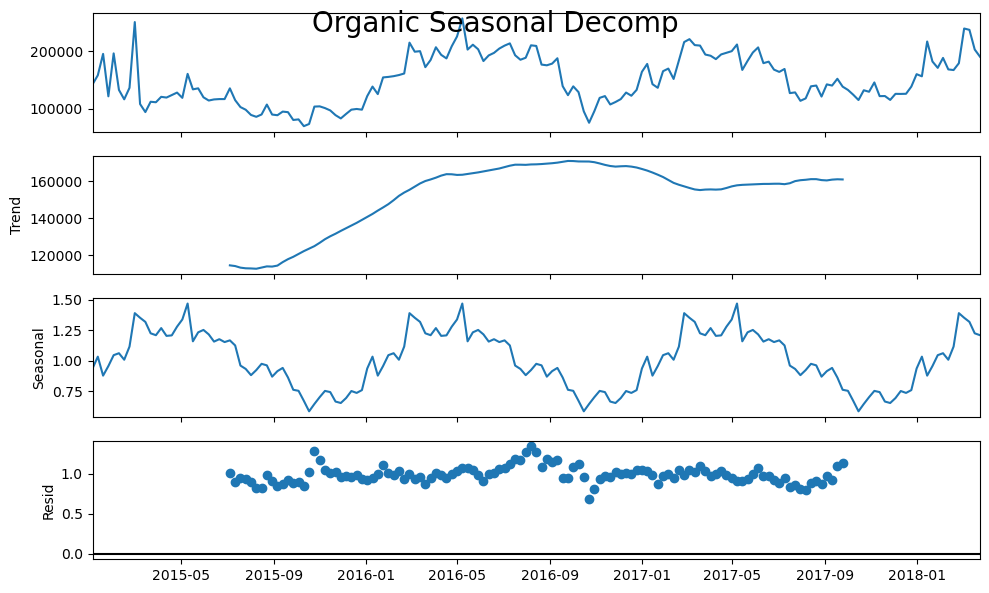

In [11]:
forg.seasonal_decompose(model='mul').plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

### Check Stationarity

In [12]:
critical_pval = 0.05
print('-'*100)
print('Conventional Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fcon.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Organic Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = forg.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Conventional Augmented Dickey-Fuller results:
the test-stat value is: -3.35
the p-value is 0.0128
the series is stationary
----------------------------------------------------------------------------------------------------
Organic Augmented Dickey-Fuller results:
the test-stat value is: -2.94
the p-value is 0.0404
the series is stationary
----------------------------------------------------------------------------------------------------


## Scalecast - Univariate

### Load Objects with Xvars:
- Find best combination of trend, lags, and seasonality monitoring the validation set (4 observations before the test set)

In [13]:
for f in (fcon,forg):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        irr_cycles = [26], # try irregular semi-annual seaosnality
        cross_validate=True,
        cvkwargs={
            'k':3,
            'test_length':13,
            'space_between_sets':4,
        }
    )
    print(f)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37']
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)
Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 

### Tune and Forecast with Selected Models
- Find optimal hyperparameters using the four out-of-sample observations then test results on test set

#### Conventional

In [14]:
fcon.tune_test_forecast(models,feature_importance=True)
best_model_con_uni = fcon.order_fcsts()[0]
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

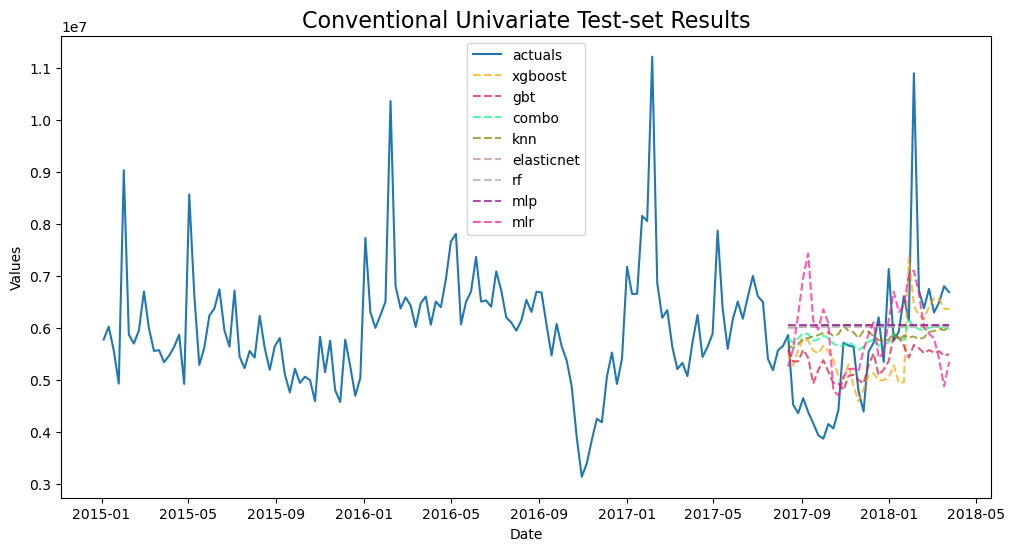

In [15]:
fcon.plot_test_set(order_by='TestSetRMSE')
plt.title('Conventional Univariate Test-set Results',size=16)
plt.show()

#### Organic

In [16]:
forg.tune_test_forecast(models,feature_importance=True)
best_model_org_uni = forg.order_fcsts()[0]
forg.set_estimator('combo')
forg.manual_forecast(how='weighted')

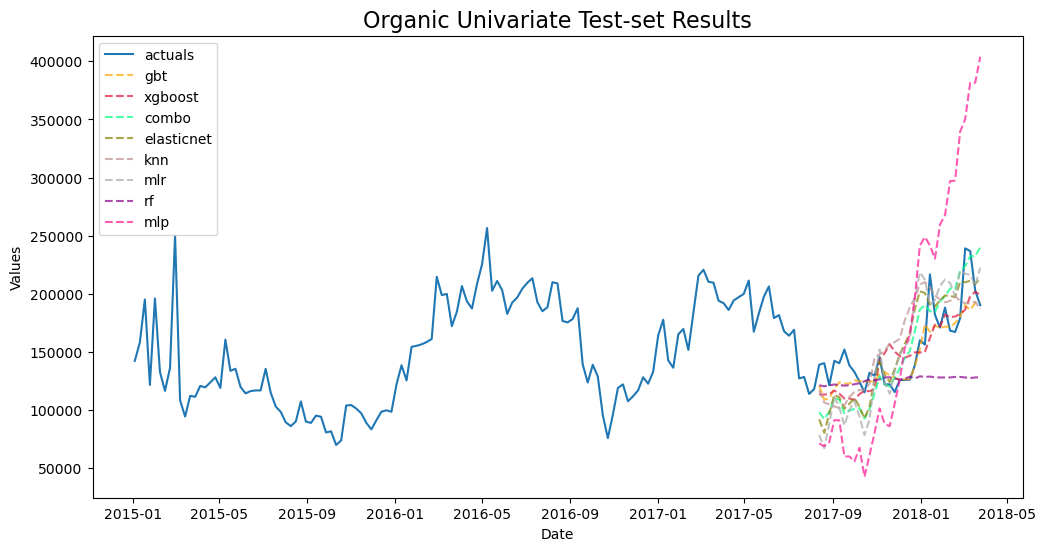

In [17]:
forg.plot_test_set(order_by='TestSetRMSE')
plt.title('Organic Univariate Test-set Results',size=16)
plt.show()

### Model Summaries

In [18]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Conventional':fcon,'Organic':forg},determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,xgboost,Conventional,1245105.6040,0.1509,877.8040,1.0000,True
1,gbt,Conventional,1269653.3000,0.1171,97685.6991,0.9937,False
2,combo,Conventional,1300936.3561,0.0731,792012.8722,0.5885,False
3,knn,Conventional,1361902.8815,-0.0158,1045866.1883,0.2824,False
4,elasticnet,Conventional,1406056.3569,-0.0828,1210620.4942,0.0385,False
5,rf,Conventional,1406169.3620,-0.0830,1238235.0271,-0.0059,False
6,mlp,Conventional,1412516.1973,-0.0927,1234622.1975,-0.0000,False
7,mlr,Conventional,1420282.0697,-0.1048,819479.4055,0.5594,False
8,gbt,Organic,19392.0789,0.6659,6209.1235,0.9732,True
9,xgboost,Organic,23906.2523,0.4923,0.9789,1.0000,False


Because running so many models can cause overfitting on the test set, we can check the average test error between all models to get another metric of how effective our modeling process is.

In [19]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'TestSetRMSE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for Conventional: 1352827.7660
univariate average test R2 for Conventional: -0.00
----------------------------------------------------------------------------------------------------
univariate average test MAPE for Organic: 38143.3444
univariate average test R2 for Organic: -0.67
----------------------------------------------------------------------------------------------------


These are interesting error metrics, but a lot of models, including XGBoost and GBT appear to be overfitting. Let's see if we can beat the results with a multivariate approach.

## Scalecast - Multivariate

### Set MV Parameters
- Forecast horizon already set
- Xvars already set
- Test size must be set: 20%
- Validation size must be set: 4 periods

In [20]:
mvf = MVForecaster(
    fcon,forg,
    names=['Conventional','Organic'],
    test_length = .2,
    valiation_length = 4,
    cis = True,
    metrics = ['rmse','r2'],
) # init the mvf object
mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['Conventional', 'Organic']
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

The lags from each Forecaster object dropped but they will be added into the multivariate models differently.

### View Series Correlation

In [21]:
mvf.corr()

,Conventional,Organic
Conventional,1.0000,0.4802
Organic,0.4802,1.0000


### View Series Correlation with each others' lags

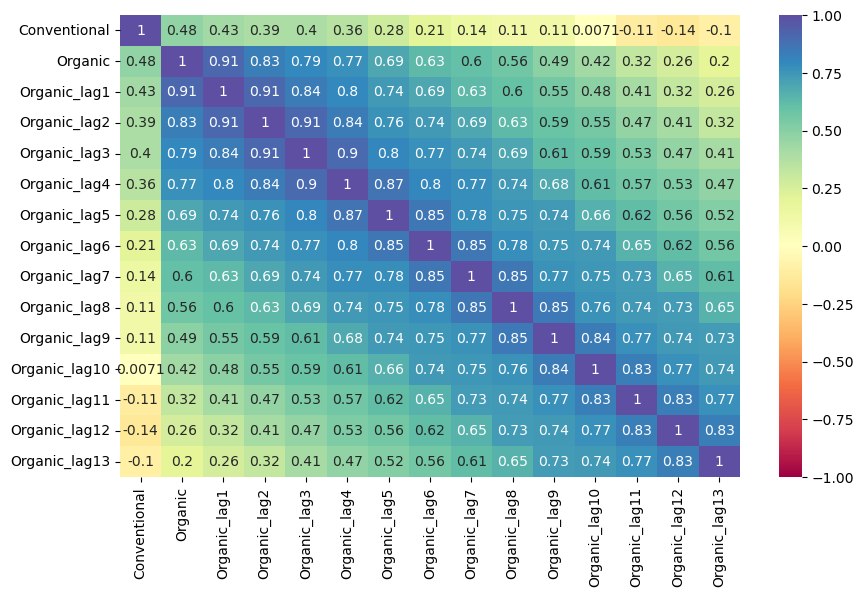

In [22]:
mvf.corr_lags(
    y='Conventional',
    x='Organic',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

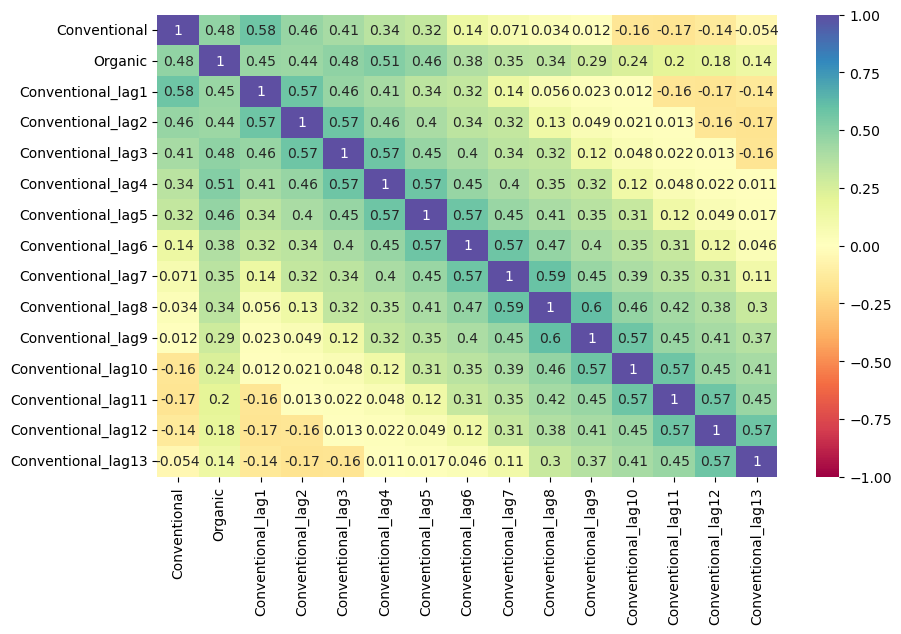

In [23]:
mvf.corr_lags(
    y='Organic',
    x='Conventional',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

### Set Optimize On
- If predicting one series is more important than predicting the other, you can use this code to let the code know to favor one over the other
- By default, it uses the mean error metrics between all series

In [24]:
# how to optimize on one series
mvf.set_optimize_on('Organic')
# how to optimize using a weighted avarage
mvf.add_optimizer_func(lambda x: x[0]*.25 + x[1]*.75,'weighted')
mvf.set_optimize_on('weighted')
# how to optimize on the average of both/all series (default)
mvf.set_optimize_on('mean')

### Tune and Test with Selected Models

In [25]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='TestSetRMSE')

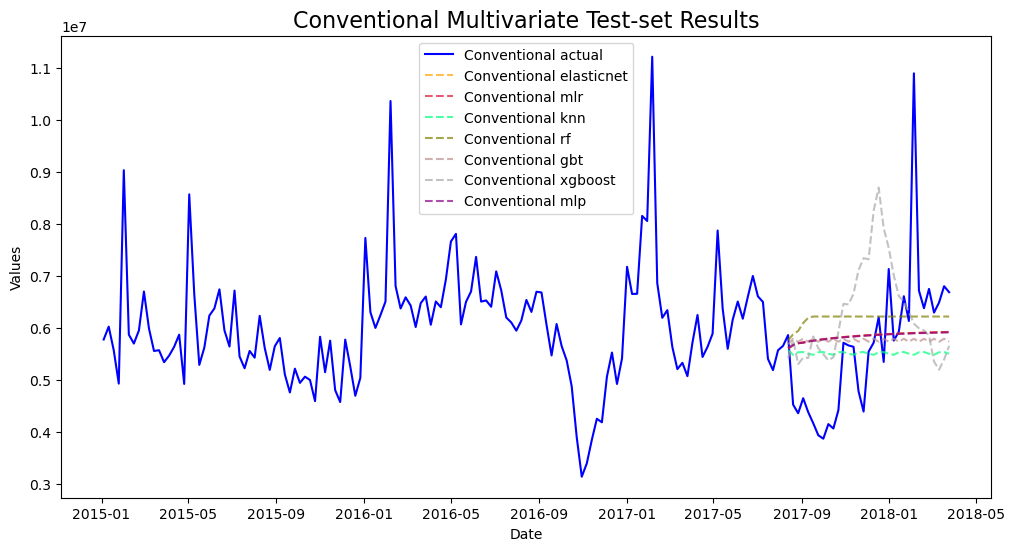

In [26]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Conventional',put_best_on_top=True)
plt.title('Conventional Multivariate Test-set Results',size=16)
plt.show()

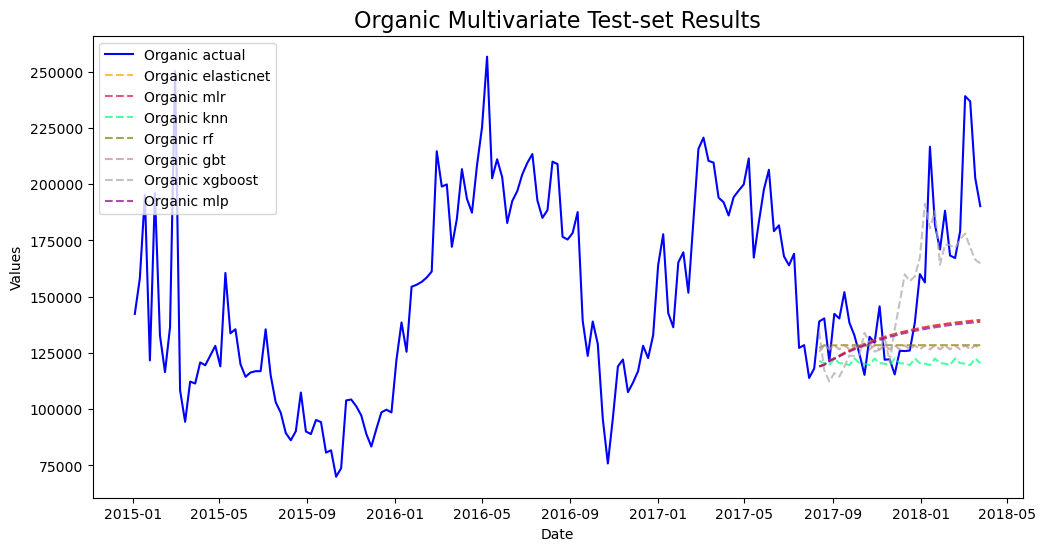

In [27]:
mvf.plot_test_set(series='Organic',put_best_on_top=True)
plt.title('Organic Multivariate Test-set Results',size=16)
plt.show()

### Export Model Summaries

In [28]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags
0,elasticnet,Conventional,"{'alpha': 0.1, 'l1_ratio': 1, 'normalizer': 'minmax'}",1322847.2344,0.0416,946032.0934,0.3446,3
1,mlr,Conventional,{'normalizer': None},1322846.6927,0.0416,946032.0934,0.3446,3
2,knn,Conventional,{'n_neighbors': 11},1359672.8693,-0.0125,888079.6817,0.4158,1
3,rf,Conventional,"{'max_depth': 2, 'n_estimators': 500, 'max_features': 'auto', 'max_samples': 0.75}",1445211.1110,-0.1439,865690.4031,0.4449,1
4,gbt,Conventional,"{'max_depth': 2, 'max_features': 'sqrt'}",1356865.2823,-0.0083,612335.6195,0.7223,1
5,xgboost,Conventional,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 0, 'subsample': 0.9}",1646711.7267,-0.4851,12461.6183,0.9999,3
6,mlp,Conventional,"{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'normalizer': 'minmax'}",1323390.6405,0.0408,946032.0935,0.3446,3
7,elasticnet,Organic,"{'alpha': 0.1, 'l1_ratio': 1, 'normalizer': 'minmax'}",37354.2408,-0.2396,22224.8516,0.7277,3
8,mlr,Organic,{'normalizer': None},37355.0088,-0.2397,22224.8516,0.7277,3
9,knn,Organic,{'n_neighbors': 11},47429.3987,-0.9985,21946.7432,0.7331,1


### Import a Foreign Sklearn Estimator for Ensemble Modeling

In [29]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
estimators = [
    (
        'mlr',
        LinearRegression()
    ),
    (
        'elasticnet',
        ElasticNet(
            **{
                k:v for k,v in (
                    results.loc[
                        results['ModelNickname'] == 'elasticnet',
                        'HyperParams',
                    ].values[0]
                ).items() if k != 'normalizer'
              }
        )
    ),
    (
        'mlp',
        MLPRegressor(
            **{
                k:v for k,v in (
                    results.loc[
                        results['ModelNickname'] == 'mlp',
                        'HyperParams',
                    ].values[0]
                ).items() if k != 'normalizer'
              }
        )
    )
]

final_estimator = KNeighborsRegressor(
    **{
        k:v for k,v in (
            results.loc[
                results['ModelNickname'] == 'knn',
                'HyperParams',
            ].values[0]
        ).items() if k != 'normalizer'
      }
)

In [30]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

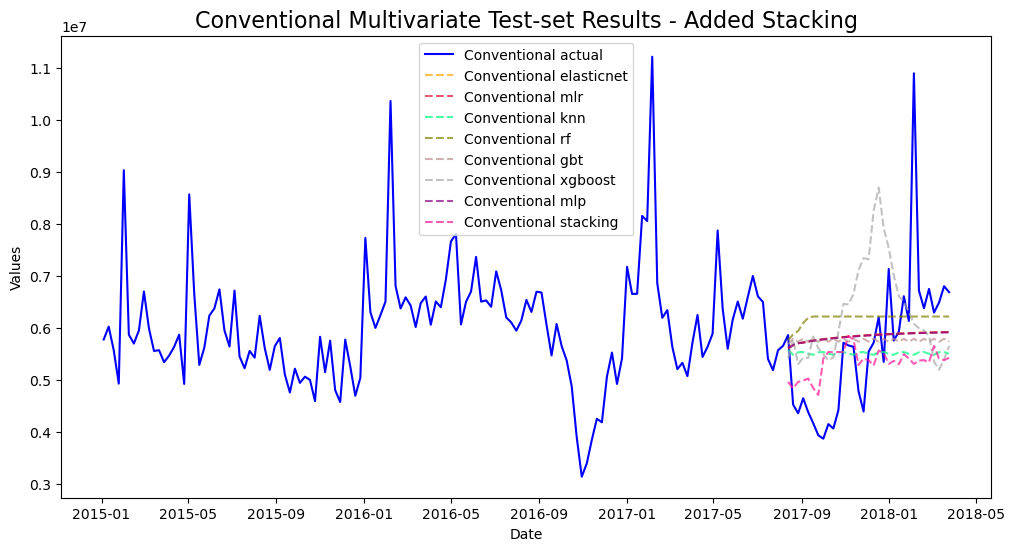

In [31]:
mvf.plot_test_set(series='Conventional',put_best_on_top=True)
plt.title('Conventional Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

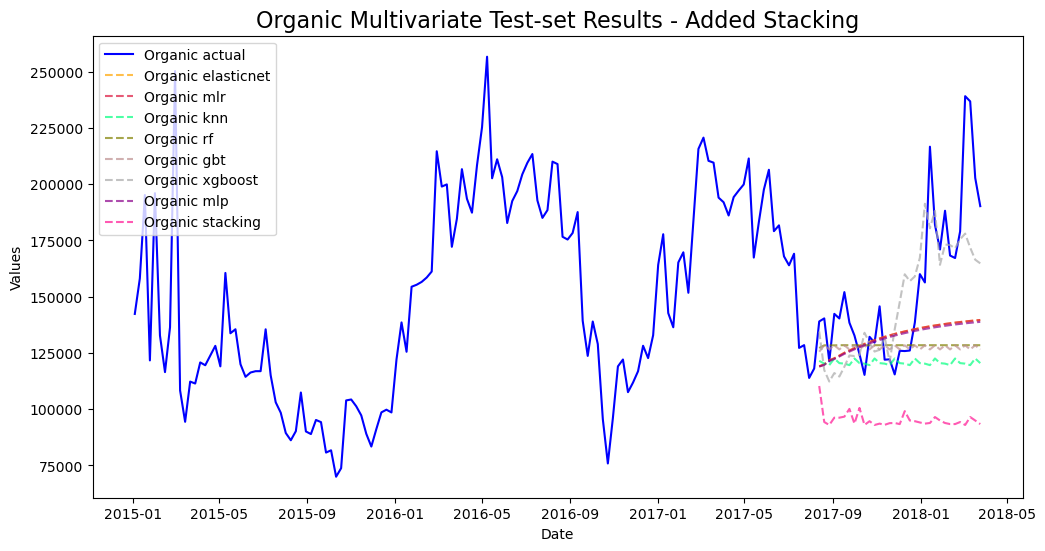

In [32]:
mvf.plot_test_set(series='Organic',put_best_on_top=True)
plt.title('Organic Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [33]:
mvf.set_best_model(determine_best_by='TestSetRMSE')
results2 = mvf.export('model_summaries')
results2 = results2[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

results2

,ModelNickname,Series,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags,best_model
0,elasticnet,Conventional,1322847.2344,0.0416,946032.0934,0.3446,3,True
1,mlr,Conventional,1322846.6927,0.0416,946032.0934,0.3446,3,False
2,knn,Conventional,1359672.8693,-0.0125,888079.6817,0.4158,1,False
3,rf,Conventional,1445211.1110,-0.1439,865690.4031,0.4449,1,False
4,gbt,Conventional,1356865.2823,-0.0083,612335.6195,0.7223,1,False
5,xgboost,Conventional,1646711.7267,-0.4851,12461.6183,0.9999,3,False
6,mlp,Conventional,1323390.6405,0.0408,946032.0935,0.3446,3,False
7,stacking,Conventional,1341715.4126,0.0141,858774.8674,0.4644,13,False
8,elasticnet,Organic,37354.2408,-0.2396,22224.8516,0.7277,3,True
9,mlr,Organic,37355.0088,-0.2397,22224.8516,0.7277,3,False


In [34]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'TestSetRMSE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Conventional: 1389907.6212
multivariate average test R2 for Conventional: -0.06
----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Organic: 42265.3404
multivariate average test R2 for Organic: -0.70
----------------------------------------------------------------------------------------------------


### Plot Final Forecasts

In [35]:
best_model_con = (
    results2.loc[results2['Series'] == 'Conventional']
    .sort_values('TestSetR2',ascending=False)
    .iloc[0,0]
)

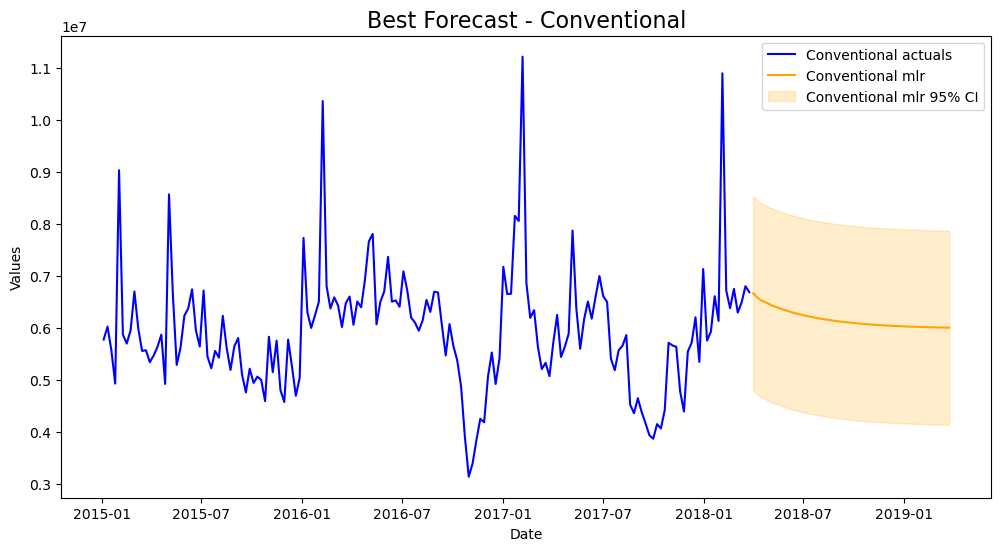

In [36]:
mvf.plot(series='Conventional',models=best_model_con,ci=True)
plt.title('Best Forecast - Conventional',size=16)
plt.show()

In [37]:
best_model_org = (
    results2.loc[results2['Series'] == 'Organic']
    .sort_values('TestSetR2',ascending=False)
    .iloc[0,0]
)

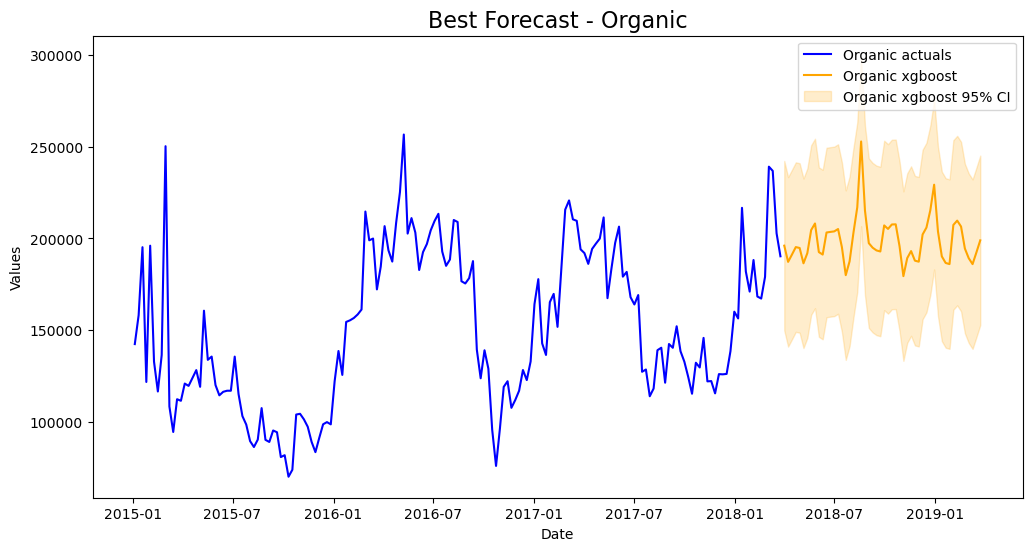

In [38]:
mvf.plot(series='Organic',models=best_model_org,ci=True)
plt.title('Best Forecast - Organic',size=16)
plt.show()

All-in-all, better results on the test-set were obtained by using the multivariate approach.

## Multivariate Backtest

Just like in univariate modeling, we can evaluate the results of this modeling approach using backtesting.

In [39]:
from scalecast.Pipeline import Transformer, Reverter, MVPipeline
from scalecast.util import backtest_metrics

def mvforecaster(mvf):
    mvf.add_seasonal_regressors('month','quarter',raw=False,sincos=True)
    mvf.tune_test_forecast(
        models=[best_model_con,best_model_org],
    )

pipeline = MVPipeline(
    steps = [('Forecast',mvforecaster)],
    validation_length = 4,
)

In [40]:
backtest_results = pipeline.backtest(
    fcon,
    forg,
    cis=False,
    test_length = 0,
    fcst_length = 52,
    jump_back = 4,
    n_iter = 3,
)

In [41]:
backtest_metrics(
    backtest_results,
    mets=['rmse','r2'],
    names=['Conventional','Organic'],
)

Iter0        Iter1        Iter2  \
Series       Model   Metric                                          
Conventional mlr     rmse   1015488.5640 1057408.4626 1046510.8889   
                     r2           0.2422       0.1573       0.2071   
             xgboost rmse   1006224.1405 1383342.2268 1336228.1896   
                     r2           0.2560      -0.4422      -0.2927   
Organic      mlr     rmse     25468.3634   21339.6433   26350.0659   
                     r2           0.4166       0.5515       0.3474   
             xgboost rmse     40211.4511   40686.4729   42517.2610   
                     r2          -0.4544      -0.6305      -0.6990   

                                 Average  
Series       Model   Metric               
Conventional mlr     rmse   1039802.6385  
                     r2           0.2022  
             xgboost rmse   1241931.5190  
                     r2          -0.1596  
Organic      mlr     rmse     24386.0242  
                     r2           0.4385  
             xgboost rmse     41138.3950  
                     r2          -0.5946